# UNet with Resnet 50 Backbone

## Initial installation

In [1]:
# %pip install torch -q
# %pip install opencv-python -q
# %pip install pycocotools -q
# %pip install timm==0.6.12 -q
# %pip install ipdb -q

## Import all dependancies

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model
import warnings
import torch
import math
import sys
import wandb
from tqdm import tqdm, trange

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Configs 

In [3]:
# Feel free to add more items here
config = {
    "lr"         : 1e-4,
    "epochs"     : 100,
    "batch_size" : 1,  # Increase if your device can handle it
    "num_classes": 1,
    'truncated_normal_mean' : 0,
    'truncated_normal_std' : 0.2,
}


# create a torch.utils.data.Dataset/DataLoader
annotation_json_path = '/home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/round_1/annotations.json'
train_img_path = '/home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/round_1/images-clean'
train_mask_path = '/home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/round_1/masks-clean'

#! Temporarily using train and val images as same
val_img_path = '/home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/sensors_2023-08-03-15-19-03_0/images'
val_mask_path = '/home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/sensors_2023-08-03-15-19-03_0/masks'

test_img_path = '/home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/sensors_2023-08-03-15-19-03_0/images'

# img_size = (1384, 1032) # = width, height            # currently PtGrey images
img_size = (1024, 1024)

checkpoint_path = '/home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/checkpoints/checkpoint.pth'


## Extract Masks from the COCO annotations (if not already done)

In [4]:
# convert_coco_to_mask(input_json=annotation_json_path, image_folder=train_img_path, output_folder=train_mask_path)

In [5]:
# Find mean and std of your dataset:
def get_mean_and_std_calculated(IMAGE_DATA_DIR):
    """
    NOTE: The ImageFolder dataloader requires the following file structure:

    root
    |
    └── cat (class label)
        |
        ├──img_2.png
        └──img_1.png

    """
    train_dataset = ImageFolder(IMAGE_DATA_DIR, transform=torchvision.transforms.ToTensor())

    # Initialize lists to store channel-wise means and standard deviations
    channel_wise_means = [0.0, 0.0, 0.0]
    channel_wise_stds = [0.0, 0.0, 0.0]

    # Iterate through the training dataset to calculate means and standard deviations
    for image, _ in train_dataset:
        for i in range(3):  # Assuming RGB images
            channel_wise_means[i] += image[i, :, :].mean().item()
            channel_wise_stds[i] += image[i, :, :].std().item()

    # Calculate the mean and standard deviation for each channel
    num_samples = len(train_dataset)
    channel_wise_means = [mean / num_samples for mean in channel_wise_means]
    channel_wise_stds = [std / num_samples for std in channel_wise_stds]

    # Print the mean and standard deviation for each channel
    print("Mean:", channel_wise_means)
    print("Std:", channel_wise_stds)

    return channel_wise_means, channel_wise_stds

# means, stds = get_mean_and_std_calculated(train_img_path_for_ImageFolder_dataloader)
means = [0.44895144719250346, 0.4951483853617493, 0.4498602793532975]
stds = [0.21388493326245522, 0.24571933703763144, 0.22413276759337405]

normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=means, std=stds) # always normalize only after tensor conversion
    ])

## Dataset 

In [6]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self,
                 img_paths,
                 mask_paths=None,
                 size=(256, 256),
                 mode='binary',
                 normalize=None,
                 transformations=None):
        
        self.img_paths = sorted(os.listdir(img_paths))
        self.img_paths = [os.path.join(img_paths, img_path) for img_path in self.img_paths]
        if mask_paths is not None:
            self.mask_paths = sorted(os.listdir(mask_paths))
            self.mask_paths = [os.path.join(mask_paths, mask_path) for mask_path in self.mask_paths]
        else:
            self.mask_paths = None
        self.size = size
        self.mode = mode
        self.normalize = normalize
        self.transformations = transformations

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert("RGB") 

        numpy_img = np.array(img, dtype=np.uint8).transpose((2, 0, 1)) 
        img = numpy_img[:, 8:, 240:-120]
        img = Image.fromarray(img.transpose((1, 2, 0)))
        img = self.transformations(img) if (self.transformations is not None) else img

        img = torch.Tensor(img) 

        img = self.normalize(img) if self.normalize is not None else img

        if self.mask_paths is not None:
            mask_path = self.mask_paths[index]
            mask = Image.open(mask_path)

            mask = np.array(mask, dtype=np.uint8) 

            mask = mask[8:, 240:-120]

            mask[:, :][mask[:, :] >= 1] = 1
            mask[:, :][mask[:, :] < 1] = 0 
            mask = np.expand_dims(mask, axis=0)
            mask = torch.as_tensor(mask, dtype=torch.uint8)
            return img, mask
        else:
            return img

In [7]:
train_transforms = torchvision.transforms.Compose([
    # To PIL Image
    # torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.ColorJitter(brightness=0.16, contrast=0.15, saturation=0.1),
    torchvision.transforms.RandomRotation(18),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    torchvision.transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    torchvision.transforms.ToTensor(),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = SemanticSegmentationDataset(img_paths=train_img_path, mask_paths=train_mask_path, size=img_size, mode='binary', normalize=normalize_transform, transformations=train_transforms)
val_dataset = SemanticSegmentationDataset(img_paths=val_img_path, mask_paths=val_mask_path, size=img_size, mode='binary', normalize=normalize_transform, transformations=val_transforms)
test_dataset = SemanticSegmentationDataset(img_paths=val_img_path, mask_paths=None, size=img_size, normalize=normalize_transform, transformations=test_transforms)

temp = train_dataset.__getitem__(1)

# Create data loaders
train_loader = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True
)

val_loader = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

test_loader = DataLoader(
    dataset     = test_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    drop_last   = False,
    num_workers = 2)

# Unet Model

reference: https://github.com/mberkay0/pretrained-backbones-unet

In [8]:

class Unet(nn.Module):
    def __init__(
            self,
            backbone='resnet50',
            encoder_freeze=False,
            pretrained=True,
            preprocessing=False,
            non_trainable_layers=(0, 1, 2, 3, 4),
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_channels=3,
            num_classes=1,
            center=False,
            norm_layer=nn.BatchNorm2d,
            activation=nn.ReLU
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}

        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, 
            in_chans=in_channels, pretrained=pretrained, **backbone_kwargs
        )
        encoder_channels = [info["num_chs"] for info in encoder.feature_info][::-1]
        self.encoder = encoder
        if preprocessing:
            self.mean = self.encoder.default_cfg["mean"] 
            self.std = self.encoder.default_cfg["std"]
        else:
            self.mean = None
            self.std = None

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
            activation=activation
        )

    def forward(self, x: torch.Tensor):
        if self.mean and self.std:
            x = self._preprocess_input(x)
        x = self.encoder(x)
        x.reverse()  
        x = self.decoder(x)
        return x

    @torch.no_grad()
    def predict(self, x):
        if self.training: 
            self.eval()
        x = self.forward(x)
        return x


    def _preprocess_input(self, x, input_range=[0, 1], inplace=False):
        if not x.is_floating_point():
            raise TypeError(f"Input tensor should be a float tensor. Got {x.dtype}.")

        if x.ndim < 3:
            raise ValueError(
                f"Expected tensor to be a tensor image of size (..., C, H, W). Got tensor.size() = {x.size()}"
            )

        if not inplace:
            x = x.clone()

        dtype = x.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=x.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=x.device)
        if (std == 0).any():
            raise ValueError(f"std evaluated to zero after conversion to {dtype}, leading to division by zero.")
        if mean.ndim == 1:
            mean = mean.view(-1, 1, 1)
        if std.ndim == 1:
            std = std.view(-1, 1, 1)
        return x.sub_(mean).div_(std)

# UNet Blocks

class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, activation=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, 
            stride=stride, padding=padding, bias=False
        )
        self.bn = norm_layer(out_channels)
        self.act = activation(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, scale_factor=2.0, 
        activation=nn.ReLU, norm_layer=nn.BatchNorm2d
    ):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, activation=activation)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip= None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):
    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=True,
            activation=nn.ReLU
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(
                channels, channels, scale_factor=1.0, 
                activation=activation, norm_layer=norm_layer
            )
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]

        out_channels = decoder_channels

        if len(in_channels) != len(out_channels):
            in_channels.append(in_channels[-1]//2)

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

# Loss function

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, from_logits=False, smooth=1e-7, eps=1e-7, reduction=None):
        super(DiceLoss, self).__init__()
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.reduction = reduction

    def forward(self, y_pred, y_true):
        if not self.from_logits: y_pred = F.sigmoid(y_pred) 
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        
        intersection = torch.sum(y_pred * y_true)
        cardinalities = torch.sum(y_pred + y_true) + self.smooth                           
        dice = (2.0 * intersection + self.smooth) / (cardinalities + self.smooth).clamp_min(self.eps) 
        loss = 1 - dice
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction is None:
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

In [9]:
model = Unet(
    # backbone='convnext_base', # backbone network name
    backbone='resnet50',
    preprocessing=True,
    in_channels=3, # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=config["num_classes"],  # output channels (number of classes in your dataset)
    encoder_freeze=True,
    pretrained=True,
)

# model = model().to(device)

In [10]:
# Define wandb credentials

import wandb
wandb.login(key="f04483494d6e038d151d85781642caafd264d7c4") #API Key is in your wandb account, under settings (wandb.ai/settings)

run = wandb.init(
    name = "UNet_with_resnet_50", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "IDL_Project_Segmentation", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: jiyoonp (jiyooonp). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jy/.netrc


In [12]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.AdamW(params, lr=config['lr'], betas=(0.9, 0.999), weight_decay=0.05)
gamma = 0.8
milestones = [10,20,40,60,80]

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

mixed_precision_scaler = torch.cuda.amp.GradScaler()

trainer = Trainer(
    model=model,              # UNet model with Resnet50 backbone
    criterion=DiceLoss(),     # loss function
    optimizer=optimizer,
    epochs=1,
    # scaler=mixed_precision_scaler,
    lr_scheduler=scheduler,
    device=device,
    checkpoint_path=checkpoint_path
)

trainer.fit(train_loader, val_loader)

Validation: 100%|██████████| 98/98 [00:06<00:00, 14.17 validating-batch/s, loss=0.193]


Val Loss 0.2005
Saving model


Traning Model on 1 epochs: 100%|██████████| 1/1 [01:59<00:00, 119.86s/it]


# Train


In [ ]:
class Trainer:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        epochs,
        scaler=None,
        lr_scheduler=None,
        device=None,
        checkpoint_path=None
    ):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scaler = scaler
        self.lr_scheduler = lr_scheduler
        self.device = self._get_device(device) if device is None else device
        self.epochs = epochs
        self.model = model.to(self.device)
        self.checkpoint_path = checkpoint_path

    def fit(self, train_loader, val_loader):
        lowest_val_loss = 1000000

        self.train_losses_ = torch.zeros(self.epochs)
        self.val_losses_ = torch.zeros(self.epochs)
        for epoch in trange(1, self.epochs + 1, desc='Traning Model on {} epochs'.format(self.epochs)):
            self._train_one_epoch(train_loader, epoch)
            self._evaluate(val_loader, epoch)

            val_loss = self.val_losses_[epoch-1]
            train_loss = self.train_losses_[epoch-1]

            print("Val Loss {:.04f}".format(val_loss))

            curr_lr = float(self.optimizer.param_groups[0]['lr'])

            wandb.log({"train_loss":train_loss, 'validation_loss': val_loss, "learning_Rate": curr_lr})

            if val_loss <= lowest_val_loss and self.checkpoint_path is not None:
                print("Saving model")
                torch.save({'model_state_dict':self.model.state_dict(),
                            'optimizer_state_dict':self.optimizer.state_dict(),
                            'scheduler_state_dict':self.lr_scheduler.state_dict(),
                            'val_loss': val_loss,
                            'epoch': epoch}, './checkpoint.pth')
                torch.save({'model_state_dict':self.model.state_dict(),
                            'optimizer_state_dict':self.optimizer.state_dict(),
                            'scheduler_state_dict':self.lr_scheduler.state_dict(),
                            'val_loss': val_loss,
                            'epoch': epoch}, self.checkpoint_path)
                lowest_val_loss = val_loss
                wandb.save('checkpoint.pth')


    def _train_one_epoch(self, data_loader, epoch):
        self.model.train()
        losses = torch.zeros(len(data_loader))
        with tqdm(data_loader, unit=" training-batch", colour="green") as training:
            for i, (images, labels) in enumerate(training):
                training.set_description(f"Epoch {epoch}")
                images, labels = images.to(self.device), labels.to(self.device)
                with torch.cuda.amp.autocast(enabled=self.scaler is not None):
                    preds = self.model(images)
                    loss = self.criterion(preds.float(), labels.float())
                if not math.isfinite(loss):
                    msg = f"Loss is {loss}, stopping training!"
                    warnings.warn(msg)
                    sys.exit(1)
                self.optimizer.zero_grad()
                if self.scaler is not None:
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()

                training.set_postfix(loss=loss.item())
                losses[i] = loss.item()

            self.train_losses_[epoch - 1] = losses.mean()


    @torch.inference_mode()
    def _evaluate(self, data_loader, epoch):
        self.model.eval()
        losses = torch.zeros(len(data_loader))
        with tqdm(data_loader, unit=" validating-batch", colour="green") as evaluation:
            for i, (images, labels) in enumerate(evaluation):
                evaluation.set_description(f"Validation")
                images, labels = images.to(self.device), labels.to(self.device)
                preds = self.model(images)
                loss = self.criterion(preds.float(), labels.float())
                self.val_losses_[epoch - 1] = loss.item()
                evaluation.set_postfix(loss=loss.item())
                losses[i] = loss.item()

            self.val_losses_[epoch - 1] = losses.mean()


    def _get_device(self, _device):
        if _device is None:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            msg = f"Device was automatically selected: {device}"
            warnings.warn(msg)
            return device
        return _device

In [13]:
# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
    # If the checkpoint file exists, load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']  # last epoch
    val_loss = checkpoint['val_loss']  # Update the best accuracy
    # Load the checkpoint and update the scheduler state if it exists in the checkpoint
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Loaded scheduler state from checkpoint.")
    else:
        print("No scheduler state found in checkpoint.")
    print("Loaded checkpoint from:", checkpoint_path)
else:
    # If the checkpoint file does not exist, start training from scratch
    start_epoch = 0
    print("No checkpoint found at:", checkpoint_path)

print(model)

Loaded scheduler state from checkpoint.
Loaded checkpoint from: /home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/checkpoints/checkpoint.pth
Unet(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=Tru

# Test the model with your images

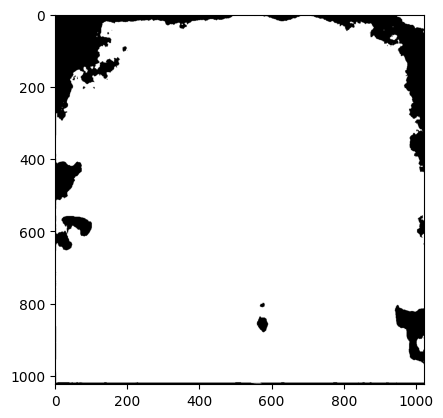

In [18]:

# Test the model
model.eval()

TEST_IMG_PATH = '/home/jy/Desktop/cmu/IDL/project/pretrained-backbones-unet/sensors_2023-08-03-15-19-03_0/images/frame000001.png'

test_img = cv2.imread(TEST_IMG_PATH)
test_img = cv2.resize(test_img, (1024, 1024))
test_img = test_transforms(test_img)
test_img = test_img.unsqueeze(0)
test_img = test_img.to(device)

with torch.no_grad():
    pred = model.predict(test_img)

pred = pred.cpu().numpy()
pred = np.squeeze(pred)

# Now pred has shape (1024, 1024)
pred = np.where(pred > 0.5, 1, 0)
pred = pred.astype(np.uint8)
pred = pred.astype(np.uint8)

plt.imshow(pred, cmap='gray')  # You can specify the colormap if needed
plt.show()